# Try to solve equilibrium interactively using spline instead.
This shouldn't cause a compile error since the compute_rotational_transform() function is agnostic to using a power series or spline.

The first set of plots is using the exact numerical values from a fixed-iota solve for current (like data["I"]) and feeds it into my compute function. This is nothing new, just establishes that compute_rotational_transform works correctly. The second set of plots is a comparison of those exact numerical values for current on a fix-iota solve to a spline fit of them. The third set of plots is giving that spline fit into the compute_rotational_transform function on a fix-iota solve equilibrium. I thought they were close enough to pursue this spline thing, so I did the interactive solve in fix-iota mode and fix-current mode and compared.

Sometimes this notebook errors with an incompatible shapes to broadcast, but rerunning it makes it go away. Weird. Make sure the compute_rotational_transform() function is set to take current from spline/power series and not the hardcoded pickle file.

DESC version 0.5.1+123.gd5b23bf.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 11.66 GB available memory


/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


If this message appears, QuadratureGrid was made.


/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


If this message appears, QuadratureGrid was made.


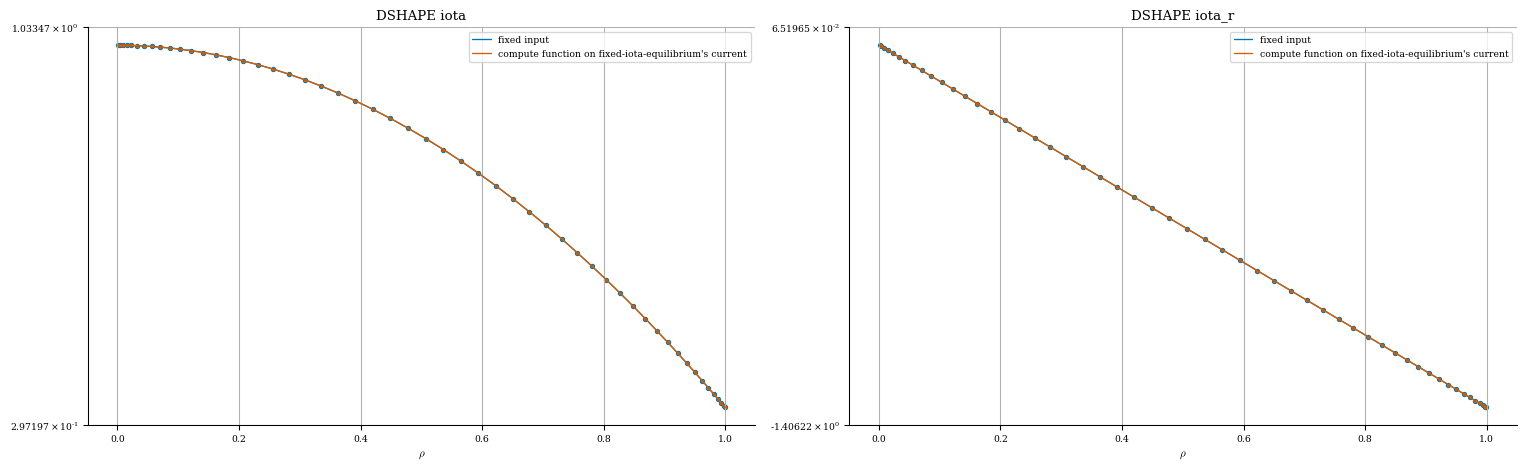

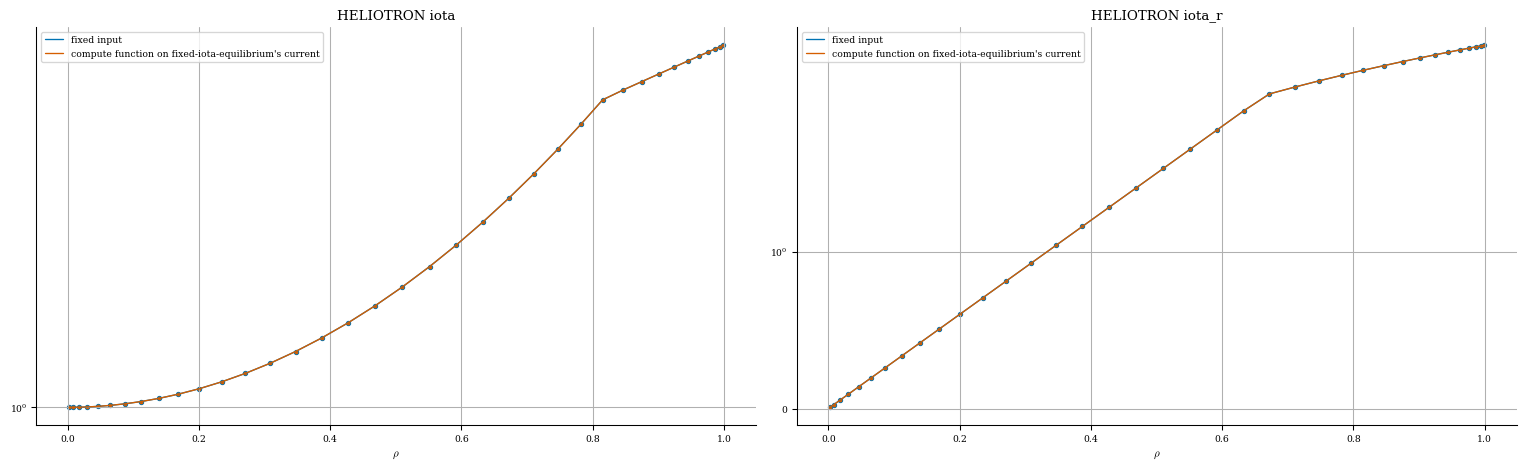

/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


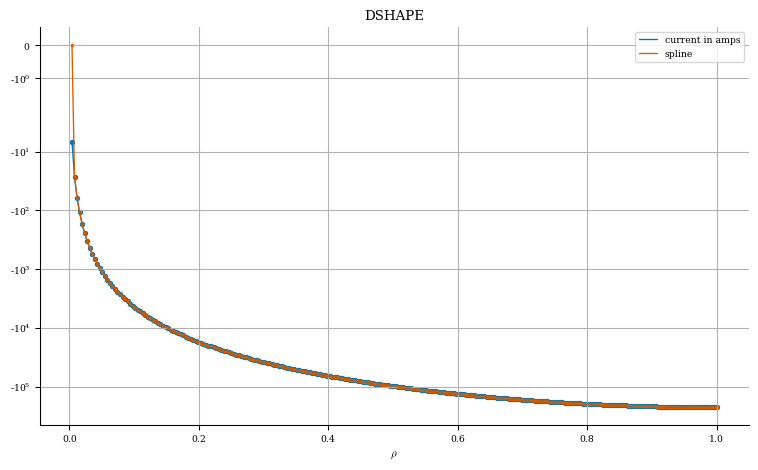

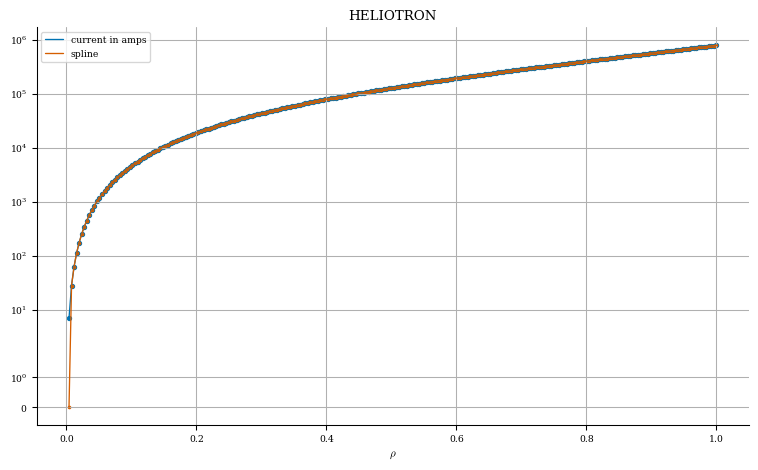

/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


If this message appears, QuadratureGrid was made.


/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


If this message appears, QuadratureGrid was made.


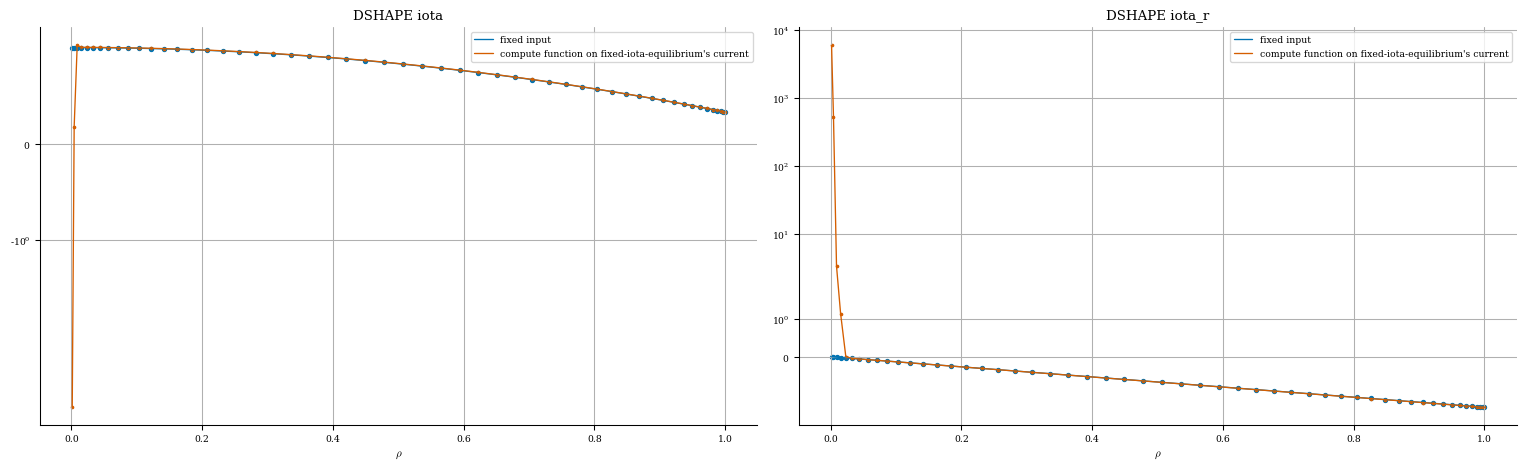

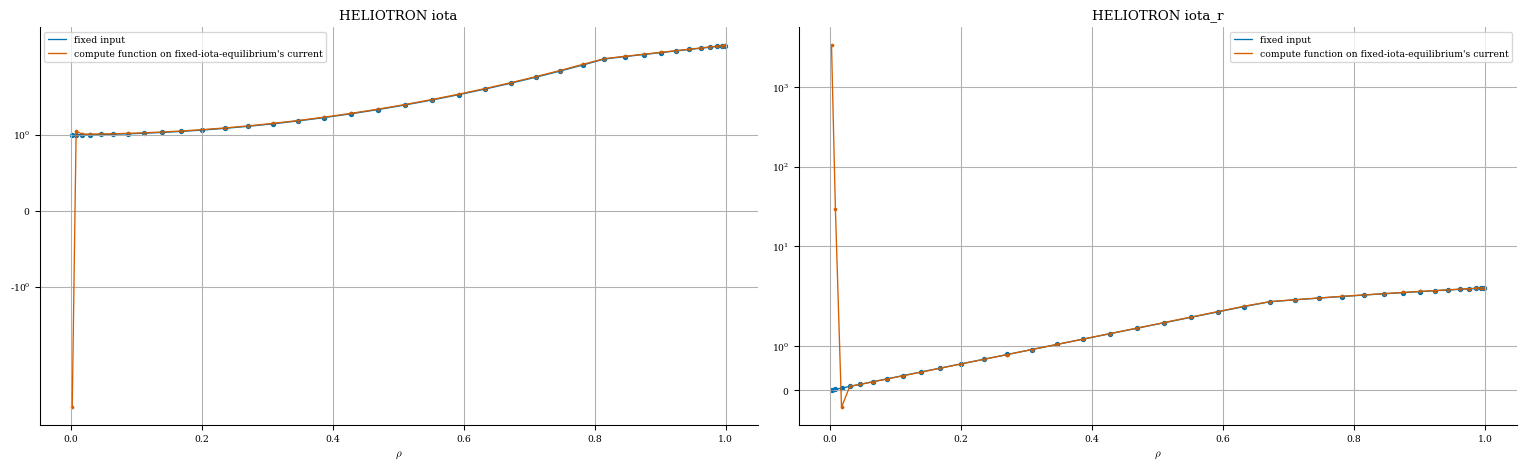

In [1]:
%run fix_current_test.ipynb

In [2]:
%matplotlib inline
import numpy as np
from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile
from desc.plotting import plot_surfaces
from desc.optimize import Optimizer

## Dshape stuff

In [3]:
# make equilibrium for dshape
surface = FourierRZToroidalSurface(
    R_lmn=[3.51, 1.0, 0.106],
    modes_R=[[0, 0], [1, 0], [2, 0]],
    Z_lmn=[1.47, -0.16],
    modes_Z=[[-1, 0], [-2, 0]],
)
rho = np.linspace(0, 1, 257)
pressure_values = 1.6e3 - 3.2e3 * rho**2 + 1.6e3 * rho**4
iota_values = 1 - 0.67 * rho**2

pressure = SplineProfile(values=pressure_values, knots=rho)
iota = SplineProfile(values=iota_values, knots=rho)
eq = Equilibrium(
    surface=surface,
    pressure=pressure,
    iota=iota,
    Psi=1.0,  # flux (in Webers) within the last closed flux surface
    NFP=1,  # number of field periods
    L=26,  # radial spectral resolution
    M=9,  # poloidal spectral resolution
    N=0,  # toroidal spectral resolution (it's a tokamak, so we don't need any toroidal modes)
    L_grid=257,
    M_grid=20,
    N_grid=0,  # real space toroidal resolution
    axis=np.asarray([0, 3.65, 0]).reshape((1, 3)),
    sym=True,  # explicitly enforce stellarator symmetry
    node_pattern="linear",
)
eq_fix_current = Equilibrium(
    surface=surface,
    pressure=pressure,
    current=dshape_spline,  # spline from fix_current_test.ipynb
    Psi=1.0,  # flux (in Webers) within the last closed flux surface
    NFP=1,  # number of field periods
    L=26,  # radial spectral resolution
    M=9,  # poloidal spectral resolution
    N=0,  # toroidal spectral resolution (it's a tokamak, so we don't need any toroidal modes)
    L_grid=257,
    M_grid=20,
    N_grid=0,  # real space toroidal resolution
    axis=np.asarray([0, 3.65, 0]).reshape((1, 3)),
    sym=True,  # explicitly enforce stellarator symmetry
    node_pattern="linear",
)

In [4]:
# mostly copied from https://desc-docs.readthedocs.io/en/latest/notebooks/Spline_Basis.html
from desc.objectives import (
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixLambdaGauge,
    FixPressure,
    FixIota,
    FixPsi,
    ForceBalance,
)
from desc.objectives.linear_objectives import FixCurrent

constraints = (
    FixBoundaryR(fixed_boundary=True),  # enforce fixed  LCFS for R
    FixBoundaryZ(fixed_boundary=True),  # enforce fixed  LCFS for R
    FixLambdaGauge(),  # Fix the gauge for Lambda (in stellarator symmetric cases, this sets lambda to zero at the magnetic axis)
    FixPressure(),  # enforce that the pressure profile stay fixed
    FixIota(),  # enforce that the rotational transform profile stay fixed
    FixPsi(),  # enforce that the enclosed toroidal stay fixed
)
constraints_fix_current = (
    FixBoundaryR(fixed_boundary=True),  # enforce fixed  LCFS for R
    FixBoundaryZ(fixed_boundary=True),  # enforce fixed  LCFS for R
    FixLambdaGauge(),  # Fix the gauge for Lambda (in stellarator symmetric cases, this sets lambda to zero at the magnetic axis)
    FixPressure(),  # enforce that the pressure profile stay fixed
    FixCurrent(),  # enforce that the rotational transform profile stay fixed
    FixPsi(),  # enforce that the enclosed toroidal stay fixed
)

In [5]:
objectives = (
    ForceBalance()
)  # choose the objectives to be ForceBalance(), which is a wrapper function for RadialForceBalance() and HelicalForceBalance()
optimizer = Optimizer("lsq-exact")
obj = ObjectiveFunction(
    objectives=objectives
)  # the final ObjectiveFunction object which we can pass to the eq.solve method
eq.solve(
    verbose=2,
    ftol=1e-2,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=500,
    objective=obj,
    optimizer=optimizer,
    constraints=constraints,
);

Building objective: force
If this message appears, ConcentricGrid was made.
Precomputing transforms
Timer: Precomputing transforms = 2.46 sec
Timer: Objective build = 2.51 sec
Compiling objective function and derivatives
Timer: Objective compilation time = 4.00 sec
Timer: Jacobian compilation time = 8.14 sec
Timer: Total compilation time = 12.1 sec
Factorizing linear constraints
Timer: linear constraint factorize = 444 ms
Number of parameters: 298
Number of objectives: 2730
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 3.559e-02
         Iterations: 69
         Function evaluations: 91
         Jacobian evaluations: 70
Timer: Solution time = 59.0 sec
Timer: Avg time per step = 856 ms
Start of solver
Total (sum of squares):  2.123e+09, 
Total force:  6.517e+04 (N)
End of solver
Total (sum of squares):  3.559e-02, 
Total force:  2.668e-01 (N)


In [6]:
objectives = (
    ForceBalance()
)  # choose the objectives to be ForceBalance(), which is a wrapper function for RadialForceBalance() and HelicalForceBalance()
optimizer = Optimizer("lsq-exact")
obj = ObjectiveFunction(
    objectives=objectives
)  # the final ObjectiveFunction object which we can pass to the eq.solve method
eq_fix_current.solve(
    verbose=2,
    ftol=1e-2,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=500,
    objective=obj,
    optimizer=optimizer,
    constraints=constraints_fix_current,
);

Building objective: force
If this message appears, ConcentricGrid was made.
Precomputing transforms
Timer: Precomputing transforms = 313 ms
Timer: Objective build = 342 ms
Compiling objective function and derivatives
Timer: Objective compilation time = 6.52 sec
Timer: Jacobian compilation time = 11.4 sec
Timer: Total compilation time = 17.9 sec
Factorizing linear constraints
Timer: linear constraint factorize = 16.0 ms
Number of parameters: 298
Number of objectives: 2730
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 3.000e+03
         Iterations: 13
         Function evaluations: 20
         Jacobian evaluations: 14
Timer: Solution time = 12.2 sec
Timer: Avg time per step = 944 ms
Start of solver
Total (sum of squares):  2.148e+09, 
Total force:  6.555e+04 (N)
End of solver
Total (sum of squares):  3.000e+03, 
Total force:  7.746e+01 (N)


(<Figure size 288x360 with 1 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

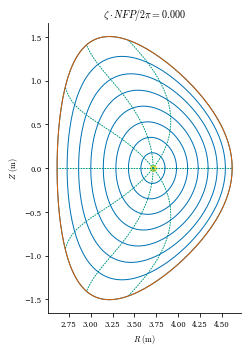

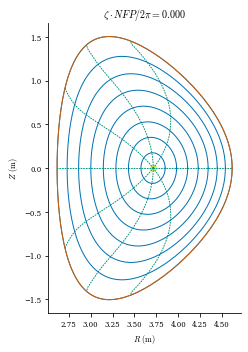

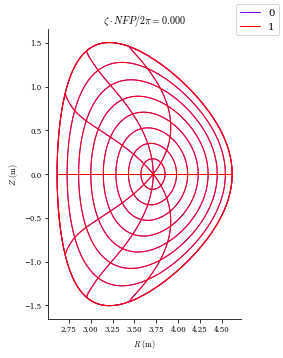

In [7]:
from desc.plotting import plot_comparison

plot_surfaces(eq)
plot_surfaces(eq_fix_current)
plot_comparison([eq, eq_fix_current])

# Heliotron stuff

In [8]:
# make equilibrium for heliotron
surface = FourierRZToroidalSurface(
    R_lmn=[1.0e1, -1.0e0, -3.0e-1, 3.0e-1],
    modes_R=[[0, 0], [1, 0], [1, 1], [-1, -1]],
    Z_lmn=[1.0e0, -3.0e-1, -3.0e-1],
    modes_Z=[[-1, 0], [-1, 1], [1, -1]],
    NFP=19,
)
rho = np.linspace(0, 1, 257)
pressure_values = 1.8e4 - 3.6e4 * rho**2 + 1.8e4 * rho**4
iota_values = 1 + 1.5 * rho**2

pressure = SplineProfile(values=pressure_values, knots=rho)
iota = SplineProfile(values=iota_values, knots=rho)
eq = Equilibrium(
    surface=surface,
    pressure=pressure,
    iota=iota,
    Psi=1.0,  # flux (in Webers) within the last closed flux surface
    NFP=19,  # number of field periods
    L=48,  # radial spectral resolution
    M=12,  # poloidal spectral resolution
    N=3,
    L_grid=65,
    M_grid=18,
    N_grid=6,  # real space toroidal resolution
    axis=np.asarray([0, 1.0e1, 0]).reshape((1, 3)),
    sym=True,  # explicitly enforce stellarator symmetry
    node_pattern="linear",
)
eq_fix_current = Equilibrium(
    surface=surface,
    pressure=pressure,
    current=heliotron_spline,  # spline from fix_current_test.ipynb
    Psi=1.0,  # flux (in Webers) within the last closed flux surface
    NFP=19,  # number of field periods
    L=48,  # radial spectral resolution
    M=12,  # poloidal spectral resolution
    N=3,
    L_grid=65,
    M_grid=18,
    N_grid=6,  # real space toroidal resolution
    axis=np.asarray([0, 1.0e1, 0]).reshape((1, 3)),
    sym=True,  # explicitly enforce stellarator symmetry
    node_pattern="linear",
)

In [10]:
objectives = (
    ForceBalance()
)  # choose the objectives to be ForceBalance(), which is a wrapper function for RadialForceBalance() and HelicalForceBalance()
optimizer = Optimizer("lsq-exact")
obj = ObjectiveFunction(
    objectives=objectives
)  # the final ObjectiveFunction object which we can pass to the eq.solve method
eq.solve(
    verbose=2,
    ftol=1e-2,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=500,
    objective=obj,
    optimizer=optimizer,
    constraints=constraints,
);

Building objective: force
If this message appears, ConcentricGrid was made.
Precomputing transforms
Timer: Precomputing transforms = 431 ms
Timer: Objective build = 463 ms
Compiling objective function and derivatives
Timer: Objective compilation time = 9.42 sec
Timer: Jacobian compilation time = 39.2 sec
Timer: Total compilation time = 48.7 sec
Factorizing linear constraints
Timer: linear constraint factorize = 31.8 ms


TypeError: sub got incompatible shapes for broadcasting: (6183,), (832,).

In [ ]:
objectives = (
    ForceBalance()
)  # choose the objectives to be ForceBalance(), which is a wrapper function for RadialForceBalance() and HelicalForceBalance()
optimizer = Optimizer("lsq-exact")
obj = ObjectiveFunction(
    objectives=objectives
)  # the final ObjectiveFunction object which we can pass to the eq.solve method
eq_fix_current.solve(
    verbose=2,
    ftol=1e-2,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=500,
    objective=obj,
    optimizer=optimizer,
    constraints=constraints_fix_current,
);